In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import os


In [ ]:
#Препроцесснуть опенсубтитры в тот же формат, что и твиты

opensub_path = "путь до plain subtitles/"

with open("где сохранить выход",'w') as fout:
    opensubtitles = {}
    for fname in os.listdir(opensub_path):
        with open(os.path.join(opensub_path,fname)) as fin:
            lines = [ln.decode('utf8')[:-1].replace('\n',' ').replace('\t',' ') for ln in fin]
            fout.write('%s\t["%s"]\n'%(fname, '", "'.join(lines).encode('utf8')))



            
            

In [2]:
#Препроцесснуть опенсубтитры в тот же формат, что и твиты


with open("Downloads/opensubtitles_all",'w') as fout:
    opensubtitles = {}

    for fname in os.listdir("./Downloads/plain_subtitles/"):

        with open("./Downloads/plain_subtitles/"+fname) as fin:

            lines = [ln.decode('utf8')[:-1].replace('\n',' ').replace('\t',' ') for ln in fin]
            
            fout.write('%s\t["%s"]\n'%(fname, '", "'.join(lines).encode('utf8')))



            
            

# Посчитаем частоты всех токенов
И заодно прихватим длины всех предложений

In [4]:
%%time
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")


token_counts = Counter()
lengths= []

with open("Downloads/opensubtitles_all",'r') as fin:
    for ln in fin:
        ln = ln.decode('utf8')
        phrases_blob = ln.split('\t')[-1]
        
        phrases = phrases_blob[2:-2].lower().split('", "')
        
        phrases_tokens = map(tokenizer.tokenize,phrases)
        
        
        for line in phrases_tokens:
            for token in line:
                token_counts[token]+=1
        lengths += map(len,phrases)

with open("Downloads/twitter_dialogues",'r') as fin:
    for ln in fin:
        ln = ln.decode('utf8')
        phrases_blob = ln.split('\t')[-1]
        
        phrases = phrases_blob[2:-2].lower().split('", "')
        
        phrases_tokens = map(tokenizer.tokenize,phrases)
        
        
        for line in phrases_tokens:
            for token in line:
                token_counts[token]+=1
        lengths += map(len,phrases)
        

CPU times: user 18min 59s, sys: 5.72 s, total: 19min 4s
Wall time: 19min 4s


# Выберем порог по частоте и построим словарь

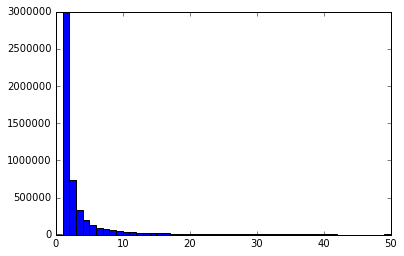

In [6]:
#распределение частот слов - большинство слов встречаются очень редко - для нас это мусор
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [70]:
#возьмём только те токены, которые встретились хотя бы 10 раз в обучающей выборке
min_count = 25


special_tokens = ["UNK","PAD"]


tokens = special_tokens+[token for (token,count) in token_counts.items() if count >= min_count ]

token_to_id = {t:i for i,t in enumerate(tokens)}




n_tokens = len(token_to_id)
print "Всего токенов:",n_tokens
print "Покрытие выборки:",sum(map(token_counts.get,tokens[2:])) *1./ sum(token_counts.values())

Всего токенов: 406012
Покрытие выборки:

NameError: name 'token_counts' is not defined

# Выберем предельную длину

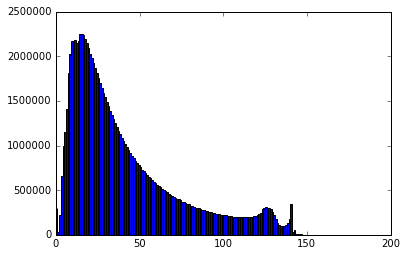

In [11]:
#Распределение на длину
_=plt.hist(lengths,range=[0,200],bins=200)

In [12]:
max_len = 150
print "Покрытие по длине:",(np.array(lengths)<=max_len).mean()

Покрытие по длине: 0.99920809457


In [13]:
# Порежем выборку на train/test
# я просто оставлю это сдесь на случай, если ты перезапустил всё во време шаффла и убил данные 
!head -n 13000000 Downloads/twitter_dialogues >Downloads/twitter_train
!tail -n +13000001 Downloads/twitter_dialogues >Downloads/twitter_test
!head -n 12000 Downloads/opensubtitles_all >Downloads/opensubtitles_train
!tail -n +12001 Downloads/opensubtitles_all >Downloads/opensubtitles_test

In [6]:
with open("Downloads/metadata",'w') as fout:
    pickle.dump((tokens,token_to_id,n_tokens,min_count,max_len),fout)

# Применение
Теперь тетрадку можно гонять начиная с этой табы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle


# Токенизируем примеры

Сначала соберём словарь всех возможных слов.
Поставим каждому слову в соответствие целое число - его id

In [2]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")


In [3]:
with open("Downloads/metadata",'r') as fin:
    (tokens,token_to_id,n_tokens,min_count,max_len) = pickle.load(fin)


print n_tokens,min_count,max_len

406011 25 150


### Заменим слова на их id
Для каждого описания установим максимальную длину. 
 * Если описание больше длины - обрежем, если меньше - дополним нулями.
 * Таким образом, у нас получится матрица размера (число объявлений)x(максимальная длина)
 * Элемент под индексами i,j - номер j-того слова i-того объявления

In [4]:
import random
def shuffle_lines(fname):
    lines = open(fname).readlines()
    random.shuffle(lines)
    open(fname, 'w').writelines(lines)

In [5]:
from itertools import izip
def FileIterator(filename, token_to_id,
                 batch_size=10,max_len=max_len,
                 null_token=0,padding_token=1, 
                 pre_shuffle=False,shuffle=True
                 
                     ):
    
    if pre_shuffle:
        print "shuffling",filename,"..."
        shuffle_lines(filename)

    batch_ix = []

    while True:

        with open(filename) as fin:

            for ln in fin:
                
                ln = ln.decode('utf8')
                phrases_blob = ln.split('\t')[-1]
                phrases = phrases_blob[2:-2].lower().split('", "')
                phrases_tokens = map(tokenizer.tokenize,phrases)
                
                for phrase_tokens in phrases_tokens:
                    token_ids = map(lambda token: token_to_id.get(token,null_token), phrase_tokens)[:max_len]
                    token_ids += [padding_token]*(max_len - len(token_ids))
                    
                    
                    batch_ix.append(token_ids)
                    
                    if len(batch_ix) ==batch_size: 
                        #Batch generated
                        yield np.array(batch_ix,dtype='int32')
                        batch_ix = []
        if shuffle:
            print "shuffling",filename,"..."
            shuffle_lines(filename)


# Поучим нейронку

Поскольку у нас есть несколько источников данных, наша нейронная сеть будет немного отличаться от того, что вы учили раньше.

* Отдельный вход для заголовка
 * свёртка + global max pool или RNN
* Отдельный вход для описания
 * свёртка + global max pool или RNN
* Отдельный вход для категориальных признаков
 * обычные полносвязные слои или какие-нибудь трюки
 
Всё это нужно как-то смешать - например, сконкатенировать

* Выход - обычный двухклассовый выход
 * 1 сигмоидальный нейрон и binary_crossentropy
 * 2 нейрона с softmax и categorical_crossentropy - то же самое, что 1 сигмоидальный
 * 1 нейрон без нелинейности (lambda x: x) и hinge loss
 

In [6]:
%env THEANO_FLAGS="device=gpu3"
#загрузим библиотеки
import lasagne
from theano import tensor as T
import theano

env: THEANO_FLAGS="device=gpu3"


Using gpu device 3: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [7]:
#3 входа и 1 выход
input_text_ids = T.matrix("phrase_token_ids",dtype='int32')

target_y = T.ivector("is_blocked")

# Архитектура нейронной сети

In [9]:

text_inp = lasagne.layers.InputLayer((None,max_len),input_var=input_text_ids)


nn = lasagne.layers.EmbeddingLayer(text_inp,input_size=len(token_to_id)+1,output_size=128)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=256,filter_size=3)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=256,filter_size=3)
nn = lasagne.layers.Pool1DLayer(nn,3)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=512,filter_size=3)
nn = lasagne.layers.Pool1DLayer(nn,3)
nn = lasagne.layers.Conv1DLayer(nn,num_filters=1024,filter_size=3)
nn = lasagne.layers.GlobalPoolLayer(nn,pool_function=T.max)





nn = lasagne.layers.DenseLayer(nn,2048)
nn = lasagne.layers.DropoutLayer(nn,p=0.1)
nn = lasagne.layers.DenseLayer(nn,2048)

nn = lasagne.layers.DenseLayer(nn,2,nonlinearity=lasagne.nonlinearities.softmax)

# Целевая функция и обновления весов

* Делаем всё стандартно:
 * получаем предсказание
 * считаем функцию потерь
 * вычисляем обновления весов
 * компилируем итерацию обучения и оценки весов

In [10]:
#Все обучаемые параметры сети
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [11]:
#Обычное предсказание нейронки
prediction = lasagne.layers.get_output(nn)


#функция потерь для prediction
loss = lasagne.objectives.categorical_crossentropy(prediction,target_y).mean()



In [12]:
#Шаг оптимизации весов
updates = lasagne.updates.adadelta(loss,weights)

### Чтобы оценивать качество сети, в которой есть элемент случайности 
 * Dropout, например,
 * Нужно отдельно вычислить ошибку для случая, когда dropout выключен (deterministic = True)
 * К слову, неплохо бы убедиться, что droput нам вообще нужен

In [13]:
#Предсказание нейронки без учёта dropout и прочего шума - если он есть
det_prediction = lasagne.layers.get_output(nn,deterministic=True)

#функция потерь для det_prediction
det_loss = lasagne.objectives.categorical_crossentropy(det_prediction,target_y).mean()


### Скомпилируем функции обучения и оценки качества

In [14]:
train_fun = theano.function([input_text_ids,target_y],[loss,prediction[:,1]],updates = updates)
eval_fun = theano.function([input_text_ids,target_y],[det_loss,det_prediction[:,1]])

# Главный цикл обучения
* Всё как обычно - в цикле по минибатчам запускаем функцию обновления весов.
* Поскольку выборка огромна, а чашки чая хватает в среднем на  100к примеров, будем на каждой эпохе пробегать только часть примеров.

In [15]:
# наш старый знакомый - итератор по корзинкам - теперь умеет работать с произвольным числом каналов (название, описание, категории, таргет)
from itertools import izip
def iterate_minibatches(corpora_0,corpora_1,
                        batch_0= 50,batch_1=50,
                        seq_len=max_len):
    
    itr_0 = FileIterator(corpora_0,token_to_id,
                         batch_0,seq_len,)
    itr_1 = FileIterator(corpora_1,token_to_id,
                         batch_1,seq_len,)
    
    batch_y = np.concatenate([np.zeros(batch_0,dtype='int32'),np.ones(batch_1,dtype='int32')])
    
    for batch_x0,batch_x1 in izip(itr_0,itr_1):
        
        batch_x = np.concatenate([batch_x0,batch_x1],axis=0)
        
        yield batch_x,batch_y


In [16]:
batch_size = 100
minibatches_per_epoch = 10**2
n_epochs=1000

In [73]:
train_iterator = iterate_minibatches(
    "Downloads/opensubtitles_train","Downloads/twitter_train",
    batch_size/2,batch_size/2,max_len
)
test_iterator = iterate_minibatches(
    "Downloads/opensubtitles_test","Downloads/twitter_test",
    batch_size/2,batch_size/2,max_len
)

In [ ]:
from collections import defaultdict

metrics = defaultdict(dict)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score



for e in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_x, b_y) in enumerate(train_iterator):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_x,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    e_loss = b_loss/b_c
    e_acc = accuracy_score(epoch_y_true,epoch_y_pred>0.5)
    e_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
    print "Train:"
    print '\tloss:',e_loss
    print '\tacc:',e_acc
    print '\tauc:',e_auc
    metrics["train loss"][e] = e_loss
    metrics["train accuracy"][e] = e_acc
    metrics["train auc"][e] = e_auc
    
    
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_x, b_y) in enumerate(test_iterator):
        if j > minibatches_per_epoch:break
            
        loss,pred_probas = train_fun(b_x,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    
    e_loss = b_loss/b_c
    e_acc = accuracy_score(epoch_y_true,epoch_y_pred>0.5)
    e_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
    print "Val:"
    print '\tloss:',e_loss
    print '\tacc:',e_acc
    print '\tauc:',e_auc
    metrics["val loss"][e] = e_loss
    metrics["val accuracy"][e] = e_acc
    metrics["val auc"][e] = e_auc



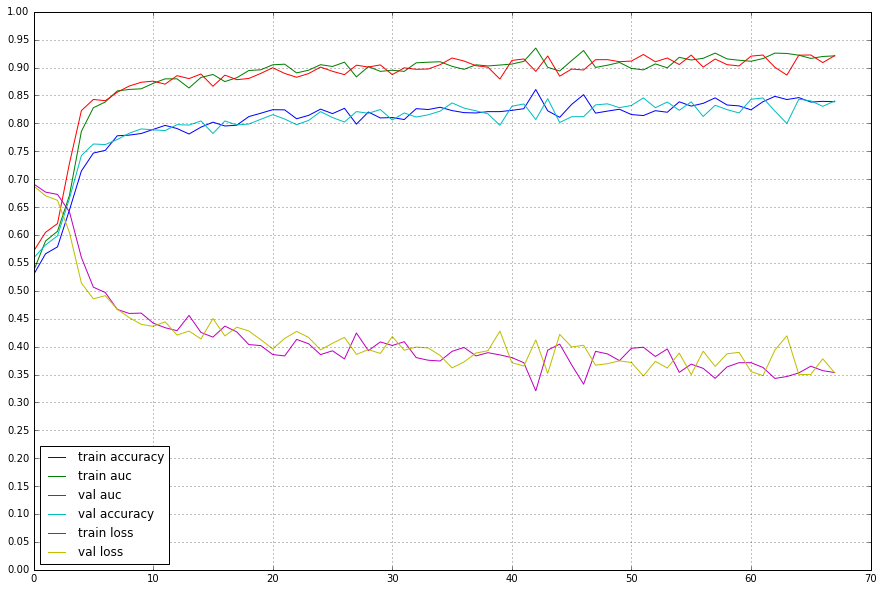

In [23]:
plt.figure(figsize=[15,10])
for metric_name in metrics:
    
    x,y = zip(*sorted(metrics[metric_name].items(), key = lambda tpl:tpl[0]))
    
    plt.plot(x,y,label=metric_name)
plt.legend(loc="best")
plt.ylim([0,1])
plt.yticks(np.arange(21)/20.)
plt.grid()

In [24]:
print "Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. \nНет, честно, file->make a copy"

Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. 
Нет, честно, file->make a copy


In [25]:
#evaluation
epoch_y_true = []
epoch_y_pred = []
epoch_x = []
b_c = b_loss = 0
for j, (b_x, b_y) in enumerate(test_iterator):
    if j > minibatches_per_epoch:break

    loss,pred_probas = train_fun(b_x,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)
    epoch_x.append(b_x)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)
epoch_x = np.concatenate(epoch_x)

In [34]:
id_to_token = {i:t for t,i in token_to_id.items()}

In [43]:
margin = ( (epoch_y_pred -0.5) * (epoch_y_true-0.5))

worst = np.argsort(margin)[:50]


for i in worst:
    
    t_seq = map(id_to_token.get,epoch_x[i])
    
    print  ["osubs","twitter"][int(epoch_y_true[i])], '->\t', ' '.join(filter(lambda s: s!="PAD",t_seq))

osubs ->	главное привыкнуть к круглосуточной блевоте и не пугаться когда вены чернеют а кости кажется превращаются в напалм а так почти как на пляже
osubs ->	завтра будем в каире потом 2 дня в танзании и в субботу в NULL
osubs ->	че за фигня
osubs ->	на самом деле такой себе никола тесла запатентовал базовую идею радио еще в 1896 году
osubs ->	вооот такие сиськи вооот такие соски
osubs ->	это вообще тут не причем
twitter ->	разумеется
osubs ->	хорошо сделала 3
twitter ->	но прямо вижу того гарри
twitter ->	здесь я здесь
osubs ->	строители думают только о том как в субботу выпьют с приятелями а на воскресенье выберутся куда то с детьми
osubs ->	лучше сходи купи пару моих любимых NULL круассанов
twitter ->	простите тот
twitter ->	вы слишком много пьете завязывайте
osubs ->	0 03 процента за 1 месяц
osubs ->	ну ладно расскажи мне про вегас да всё должно пройти спокойно ммм
twitter ->	господь кришна не велит
twitter ->	вы дне играете
osubs ->	бля
osubs ->	ну да маленько посмотрел
twitter ->